#### Utility code to convert from CSV to feather for faster load times

In [90]:
import pandas as pd
import feather

#################### READ CSV #########################
# df = pd.read_csv('./all/train.csv', parse_dates=['pickup_datetime'])
################## WRITE FEATHER ######################
# df.to_feather('./all/train.feather')
################## READ FEATHER #######################
df = pd.read_feather('./all/train.feather')

# Describe the original dataset

In [42]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,year,month,day,hour,gas
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.311976,-73.975447,40.750920,-73.974337,40.751316,1.680730,0.033990,2011.745570,6.264200,15.660600,13.985870,3.153737
std,9.468903,0.034449,0.026848,0.034143,0.030766,1.299113,0.038199,1.871184,3.451759,8.675981,6.511509,0.544924
min,0.010000,-74.248263,40.514937,-74.241953,40.484335,1.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,1.787000
25%,6.000000,-73.992272,40.736683,-73.991392,40.735743,1.000000,0.012813,2010.000000,3.000000,8.000000,9.400000,2.731000
50%,8.500000,-73.982089,40.753518,-73.980443,40.753945,1.000000,0.021851,2012.000000,6.000000,16.000000,14.616667,3.331000
75%,12.500000,-73.968348,40.767640,-73.965232,40.768427,2.000000,0.038888,2013.000000,9.000000,23.000000,19.500000,3.623000
max,165.000000,-73.702795,40.909517,-73.701188,40.917032,6.000000,0.497638,2015.000000,12.000000,31.000000,23.983333,3.933000


### Instantly recognizable outliers:
* **passenger_count**
    * Passenger counts of 0
    * Infeasible passenger counts (e.g. 200). Taxis can legally hold up to 4-6 passengers (http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml)
* **fare_amount**
    * Negative fare amounts
    * Extremely high fare amounts (thousands of dollars)
* **coordinates**
    * Invalid coordinates (out of defined range)
    * Coordinates outside of NYC

***
# Data cleaning functions:
#### Check for invalid coordinates (outside of NYC range), determined with https://www.mapdevelopers.com/geocode_bounding_box.php

In [ ]:
def valid_coordinates(lat_list, lon_list):
    for i in lat_list:
        if i < 40.477399 or i > 40.917577:
            return False
    for i in lon_list:
        if i < -74.259090 or i > -73.700272:
            return False
    return True

def clean_coordinates(df):
    df.query('~(pickup_latitude < 40.477399 or pickup_latitude > 40.917577) &\
              ~(dropoff_latitude < 40.477399 or dropoff_latitude > 40.917577) &\
              ~(pickup_longitude < -74.259090 or pickup_longitude > -73.700272) &\
              ~(dropoff_longitude < -74.259090 or dropoff_longitude > -73.700272)', inplace=True)

#### Remove invalid passenger counts, fares. Upper bound to both. Also drop missing values and key column.

In [123]:
def clean_pfdk(df):
    df.drop(columns=['key'], inplace=True)
    df.dropna(inplace=True)
    df.query('passenger_count > 0 &\
              passenger_count <= 6 &\
              fare_amount > 0 &\
              fare_amount <= 100 ', inplace=True)

***
# Feature Engineering functions:
***
#### Calculate Distance (and drop rows with distance = 0)

In [3]:
import math

def euclidean_distance(x1, y1, x2, y2):
    return ((x2-x1)**2 + (y2-y1)**2)**0.5

def manhattan_distance(x1, y1, x2, y2):
    return math.abs(x2-x1) + math.abs(y2-y1)
    
def add_euclidean_distance(df):
    df['euclidean_distance'] = euclidean_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df.query('euclidean_distance > 0', inplace=True)
    
def add_manhattan_distance(df):
    df['manhattan_distance'] = manhattan_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df.query('manhattan_distance > 0', inplace=True)

#### Extract Time Values

In [ ]:
def add_times(df):
    df['year']  = df['pickup_datetime'].dt.year
    df['month'] = df['pickup_datetime'].dt.month
    df['day']   = df['pickup_datetime'].dt.day
    df['hour']  = df['pickup_datetime'].dt.hour + (df['pickup_datetime'].dt.minute/60)

#### External data: Monthly Gas Prices acquired from https://data.bls.gov/timeseries/APU000074714

In [ ]:
def add_gas_prices(df):
    gas_df = pd.read_csv('./all/gas_prices.csv')
    gas_dict = {}
    for row in gas_df.itertuples():
        year = row[1]
        for i in range(2, len(row)):
            gas_dict['{0}-{1}'.format(year, i-1)] = row[i]
    df['year-month']  = df['year'].astype(str) + '-' + df['month'].astype(str)
    df['gas'] = df['year-month'].map(gas_dict)
    df.drop(columns=['year-month'], inplace=True)

#### Preprocess pipeline function

In [ ]:
def preprocess(df, training=True):
    if training:
        clean_pfdk(df)
        clean_coordinates(df)
        df.reset_index(drop=True, inplace=True)
    add_euclidean_distance(df)
    add_times(df)
    add_gas_prices(df)

#### Utility code to preprocess training data and save as feather

In [71]:
import pandas as pd
import feather

############## PREPROCESS TRAINING DATA $##############
# preprocess(df, training=True)
############## WRITE PREPROCESSED FEATHER #############
# df.to_feather('./all/preprocessed_train.feather')
######### READ PREPROCESSED FEATHER ###################
df = pd.read_feather('./all/preprocessed_train.feather')

19

***
# Visualization:
#### Scatter plot (Euclidean Distance, Fare Amount)

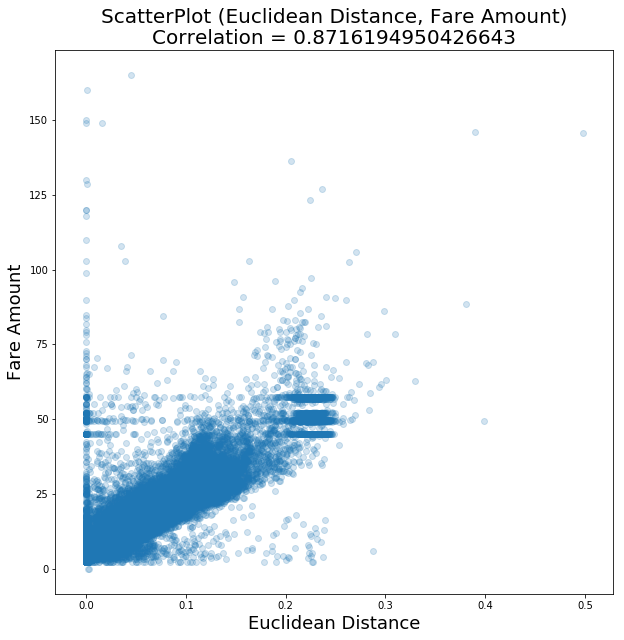

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

corr = df['euclidean_distance'].corr(df['fare_amount'])
plt.figure(figsize=(10,10))
plt.scatter(df['euclidean_distance'], df['fare_amount'], alpha=0.2)
plt.title('ScatterPlot (Euclidean Distance, Fare Amount)\nCorrelation = {0}'.format(corr), fontsize = 20)
plt.xlabel('Euclidean Distance', fontsize=18)
plt.ylabel('Fare Amount', fontsize=18)
plt.show()

Observations:
* Very strong correlation (0.87)
* There are three groups of fixed fares over any distance. This makes sense because there are usually fixed fares to JFK, Newark, and LaGuardia airports. 

#### ScatterPlot (Time of Day, Distance Traveled)

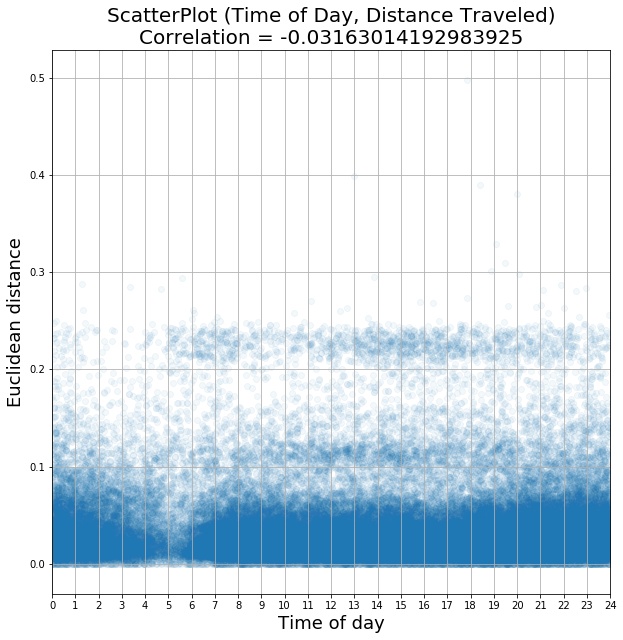

In [26]:
corr = df['hour'].corr(df['euclidean_distance'])
plt.figure(figsize=(10,10))
plt.scatter(df['hour'], df['euclidean_distance'], alpha=0.05)
plt.title('ScatterPlot (Time of Day, Distance Traveled)\nCorrelation = {0}'.format(corr), fontsize = 20)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Euclidean distance', fontsize=18)
plt.xlim(0,24)
plt.xticks(range(0,25))
plt.grid(True)
plt.show()

Observations:
* Seems to be very low/negligible correlation (-0.03)
* Naturally, less people travel in the early morning

#### ScatterPlot (Time of Day, Fare Amount)

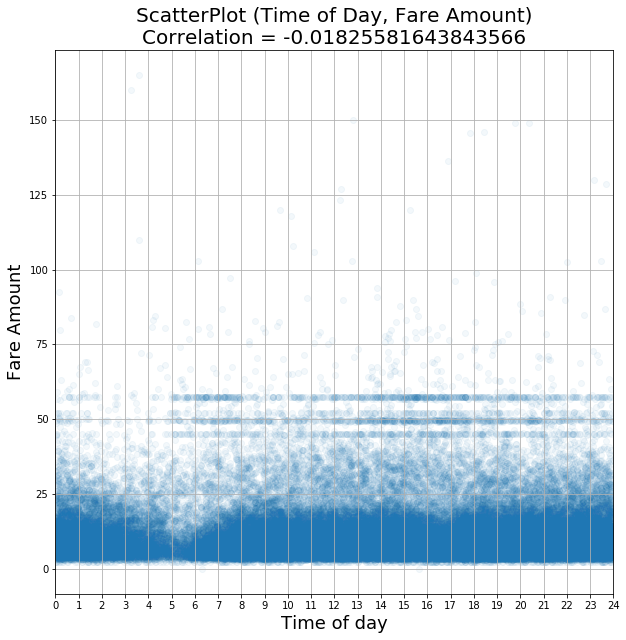

In [27]:
corr = df['hour'].corr(df['fare_amount'])
plt.figure(figsize=(10,10))
plt.scatter(df['hour'], df['fare_amount'], alpha=0.05)
plt.title('ScatterPlot (Time of Day, Fare Amount)\nCorrelation = {0}'.format(corr), fontsize = 20)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Fare Amount', fontsize=18)
plt.xlim(0,24)
plt.xticks(range(0,25))
plt.grid(True)
plt.show()

Observations:
* Correlation also very weak (-0.018)
* Three groups of fixed fares also visible here

#### Correlation Heatmap

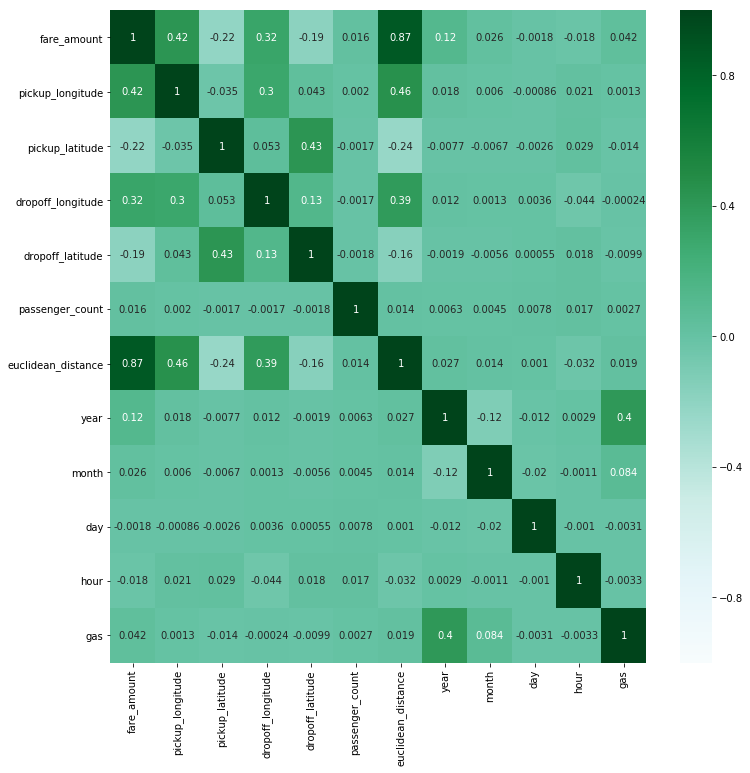

In [35]:
corr_matrix = df.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, cmap='BuGn', annot=True, vmin=-1, vmax=1)
plt.show()

Observations:
* Euclidean distance has the highest correlation with fare amount
* Latidude is negatively correlated with fare
* Longitude is positively correlated with fare
* Year has a correlation of 0.12 with fare. Makes sense since costs slowly rise with inflation.
* Gas prices and year have significant correlation (0.4)

#### Fares by Destination

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['fare_amount'], cmap=plt.get_cmap('jet'), alpha=0.05)
colorbar = plt.colorbar()
colorbar.ax.set_ylabel('Fare Amount', fontsize=20)
plt.title('Fares by Destination'.format(corr), fontsize = 20)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.show()

KeyboardInterrupt: 

***   
# Train/Test split wrapper function
Can specify number of rows to train on, test subset size, and whether or not to scale.

In [ ]:
# SPLIT TRAIN/TEST DATA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_tt_split(rows, test_size=0.005, scale_X=False):
    X = df.head(rows)[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour', 'euclidean_distance', 'passenger_count', 'gas']]
    y = df.head(rows)['fare_amount']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=3)
    
    if scale_X:
        X_train = StandardScaler().fit_transform(X_train)
        X_test  = StandardScaler().fit_transform(X_test)
        
    return X_train, X_test, y_train, y_test

***
# Model: Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

X_train, X_test, y_train, y_test = get_tt_split(len(df), scale_X=False)
model.fit(X_train, y_train)

test_predictions = model.predict(X_test)
print('Mean Squared Error:', mean_squared_error(y_test, test_predictions))
print('\nCOEFFICIENTS:')
for i in list(zip(X_test.columns, model.coef_)):
    print('{0}: {1}'.format(i[0], i[1]))
print('==============================')
print('\nINTERCEPT:', model.intercept_)

Observations:
* most important feature:

# Model: Decision Tree Ensembles (XGBoost)

In [ ]:
# XGBOOST (DECISION TREE ENSEMBLES)

import xgboost as xgb
from xgboost import DMatrix
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = get_tt_split(len(df), scale_X=False)
model = xgb.train(params={'eta':0.2}, dtrain=DMatrix(X_train, y_train))

test_predictions = model.predict(xgb.DMatrix(X_test))
print('Mean Squared Error:', mean_squared_error(y_test, test_predictions))

# Model: Neural Network

In [ ]:
# NEURAL NETWORK

import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.train import RMSPropOptimizer
from tensorflow.nn import relu, softmax
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = get_tt_split(1000, scale_X=False)

shape = (len(X_train.columns),)
learning_rate = 0.01

model = keras.Sequential([Dense(32, input_shape=shape), Dense(32, activation=relu), Dense(32, activation=relu), Dense(1)])

model.compile(loss='mse', metrics=['mse'], optimizer=RMSPropOptimizer(learning_rate))
model.fit(X_train, y_train, epochs=1000, verbose=0)

test_predictions = [i[0] for i in model.predict(X_test)]
print('Mean Squared Error:', mean_squared_error(y_test, test_predictions))

# Preprocess/fit model to real test data

In [5]:
real_df = pd.read_csv('./all/test.csv', parse_dates=['pickup_datetime'])
preprocess(real_df, training=False)

# FIT MODEL TO ACTUAL DATA
selected_model = 'xgb'
scaled = False

real_X = real_df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'year', 'month', 'day', 'hour', 'euclidean_distance', 'passenger_count', 'gas']]

if scaled:
    real_X = StandardScaler().fit_transform(real_X)

if selected_model == 'xgb':
    predictions = model.predict(xgb.DMatrix(real_X))

if selected_model == 'nn':
    predictions = [i[0] for i in model.predict(real_X)]

data = list(zip(real_df['key'], predictions))

submission = pd.DataFrame(data, columns=['key', 'fare_amount'])
submission.set_index('key', inplace=True)
submission.to_csv('submission.csv')

NameError: name 'pd' is not defined

## Kaggle Scores by model (RMSE):
* Linear Regression:
* Neural Network:
* Decision Tree Ensembles (XGBoost):    <---